In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

# Classes

### Community Class

In [0]:
class Community:

  # initalization method
  def __init__(self, name, space_size):

    self.name = name # name of the community
    self.space = np.zeros((space_size,space_size)) # numpy array that represents the physical space
    self.population = self.space.size # the size of the population
    self.susceptible = self.space.size # the current number of healthy people in the population
    self.infected = 0 # the current number of infected people in the population
    self.recovered = 0 # the current number of infected people in the population
    self.snapshots = [] # this will contain numpy arrays that represent each time step
    self.SIR = np.zeros((3,1)) #this contains a time series of the number of susceptible, infected, recovered
    self.time = np.zeros(1) # this array will be the time array
    self.base_infection_probability = 0 # this is the base infection probability
    self.infection_probability = 0 # this is the infection probability applied to all the population in this community
    self.recovery_probability = 0 # this is the probability of recovering if the person is infected
    self.peak_number_of_infections = 0 # this is the peak number of infected people at the same time during the simulation
    self.total_infections = 0 # this is the total number of people that were infected or are currently infected at the time where the outbreak ends
    self.duration_of_outbreak = 0 # this is the number of time steps that the outbreaks lasts, calculated to be the 
                                  # time step after the peak where the number of infected is for the first time less 
                                  # than 10% of the peak number of infected 

  def resetSimulatedData(self):
    self.space = 0*self.space # numpy array that represents the physical space
    self.susceptible = self.space.size # the current number of healthy people in the population
    self.infected = 0 # the current number of infected people in the population
    self.recovered = 0 # the current number of infected people in the population
    self.snapshots = [] # this will contain numpy arrays that represent each time step
    self.SIR = np.zeros((3,1)) #this contains a time series of the number of susceptible, infected, recovered
    self.time = np.zeros(1) # this array will be the time array

  # method to add the initially infected
  def addInitiallyInfected(self, number_initially_infected):

    x_infected = 0
    y_infected = 0
    
    # place as many infected as required in this loop
    while self.infected < number_initially_infected:
        
        # randomly generate the position
        x_infected = np.random.randint(0,self.space.shape[0])
        y_infected = np.random.randint(0,self.space.shape[1])
        
        # check that the position isn't already occupied by an infected
        if (self.space[x_infected][y_infected] == 0):
            self.space[x_infected][y_infected] = 1
            self.infected += 1
    
    # add the initial values of healthy/infected to the arrays keeping track
    self.SIR[0, 0] = self.getSusceptible()
    self.SIR[1, 0] = self.getInfected()

    # add the first snapshot of the simulation
    self.snapshots.append(self.getSpace().copy())


  # method that simulates one time step
  def simulateOneTimeStep(self):
    self.susceptibleToInfected()
    self.infectedToRecovered()
    
    # add the new values of healthy/infected/recovered to the arrays keeping track
    SIR_t = np.array([self.getSusceptible(), self.getInfected(), self.getRecovered()])
    #update SIR time series
    self.SIR = np.concatenate([self.SIR, SIR_t[:,np.newaxis]], axis=1)

    # add the new snapshot of the simulation
    self.snapshots.append(self.getSpace().copy())
    
  def susceptibleToInfected(self):

    #create a mask to sieve those uninfected out
    infected = self.space == 1

    # add extra boundaries
    expan1 = np.hstack((infected,np.zeros((self.space.shape[0],1))))
    expan1 = np.vstack((expan1,np.zeros((1,expan1.shape[1]))))
    expan1 = np.hstack((np.zeros((expan1.shape[0],1)),expan1))
    expan1 = np.vstack((np.zeros((1,expan1.shape[1])),expan1))

    # make the addition for how many infected are around each position
    expan2 = (expan1[:-2,:-2] + 
              expan1[:-2,1:-1] + 
              expan1[:-2,2:] + 
              expan1[1:-1,2:] + 
              expan1[2:,2:] + 
              expan1[2:,1:-1] + 
              expan1[2:,0:-2] + 
              expan1[1:-1,0:-2])
    
    exposedToRisk = np.logical_and(expan2 > 0, self.space == 0)
    # initialize a random matrix where around infection_probability % of the values are True
    infect_prob_arr = np.random.rand(self.space.shape[0], self.space.shape[1]) < self.infection_probability
    # find the overlap between healthy and 
    self.space[np.logical_and(exposedToRisk, infect_prob_arr)] = 1

  def infectedToRecovered(self):
    # initialize a random matrix where around recovery_probability % of the values are True
    recover_prob_arr = np.random.rand(self.space.shape[0],self.space.shape[1]) < self.recovery_probability
    # find the overlap between infected and above array and make those people recovered
    self.space[np.logical_and(self.space == 1, recover_prob_arr)] = 2

  # method that performs a consecutive number of time steps in our simulation

  # get methods
  def getSpace(self):
    return self.space

  def getName(self):
    return self.name

  def getPopulation(self):
    return self.population

  def getSusceptible(self):

    # use a mask and sum it to see the number of healthy people, designated as having a value equal to zero
    self.susceptible = np.sum((self.getSpace()) == 0)
    
    return self.susceptible

  def getInfected(self):

    # use a mask and sum it to see the number of infected people, designated as having a value equal to one
    self.infected = np.sum((self.getSpace()) == 1)

    return self.infected

  def getRecovered(self):

    # use a mask and sum it to see the number of recovered people, designated as having a value equal to two
    self.recovered = np.sum((self.getSpace()) == 2)

    return self.recovered


  # set methods
  def setBaseInfectionProbability(self, probability):
    self.base_infection_probability = probability

  def calculateInfectionProbability(self, r):
    self.infection_probability = self.base_infection_probability * (1 - r)

  def setRecoveryProbability(self, probability):
    self.recovery_probability = probability


### Simulator Class

In [0]:
class Simulator():

  def __init__(self, communitiesDict):

    self.communitiesDict = communitiesDict
    self.resultsDict = {}

    for name in communitiesDict.keys():
      self.resultsDict[name] = {'max_infected_array': np.zeros(0),
                                'total_infected_array': np.zeros(0),
                                'duration_array': np.zeros(0)}

  def multipleTimeSteps(self, num_timesteps, plot=False):
    for tp in np.arange(num_timesteps):
      pass
  
  def migrationSimulationofTwoCommunities(self, com1, com2, numSwapped, simulationSteps, plot=False):
    for _ in np.arange(simulationSteps):
        swapIndices = np.random.permutation(com1.population)[:numSwapped]
        com1xswap, com1yswap = swapIndices // com1.space.shape[0], swapIndices % com1.space.shape[1]

        swapIndices2= np.random.permutation(com2.population)[:numSwapped]
        com2xswap, com2yswap = swapIndices2 // com2.space.shape[0], swapIndices2 % com2.space.shape[1]

        #tmp = com2.space[com2xswap, com2yswap]

        #if com1.population > com2.population:
        tmp = com1.space[com1xswap, com1yswap]

        com1.space[com1xswap, com1yswap] = com2.space[com2xswap, com2yswap]
        com2.space[com2xswap, com2yswap] = tmp
    
        com1.simulateOneTimeStep()
        com2.simulateOneTimeStep()

    # # append the maximum number of infected at a single time step
    # com1['max_infected_array'] = np.append(com1.['max_infected_array'], self.communitiesDict[name].peak_number_of_infections)
    # com2['max_infected_array'] = np.append(com2.['max_infected_array'], self.communitiesDict[name].peak_number_of_infections)  

    # # append the duration of the outbreak
    # com1['duration_array'] = np.append(com1.['duration_array'], 
    #                                                          self.communitiesDict[name].duration_of_outbreak)
    # com2['duration_array'] = np.append(com2.['duration_array'], 
    #                                                          self.communitiesDict[name].duration_of_outbreak)

    # # append the total number of people that are or were infected at the time step where the outbreak ends
    # com1['total_infected_array'] = np.append(com1.['total_infected_array'], 
    #                                                                self.communitiesDict[name].total_infections)
    # com2['total_infected_array'] = np.append(com2.['total_infected_array'], 
    #                                                                self.communitiesDict[name].total_infections)
    #counter=1
    #print(counter, end=' ')
    #counter += 1

    com1.time = np.arange(simulationSteps+1)
    com2.time = np.arange(simulationSteps+1)

    if plot:
      s = 5
      fig, (ax1, ax2) = plt.subplots(2, sharex=True)
      #fig.suptitle('Time (in units of time)')
      ax1.scatter(com1.time, com1.SIR[0], label='healthy', s=s)
      ax1.scatter(com1.time, com1.SIR[1], label='infected', s=s)
      ax1.scatter(com1.time, com1.SIR[2], label='recovered', s=s)

      ax2.scatter(com2.time, com2.SIR[0], label='healthy', s=s)
      ax2.scatter(com2.time, com2.SIR[1], label='infected', s=s)
      ax2.scatter(com2.time, com2.SIR[2], label='recovered', s=s)

      ax1.set_ylabel('Number of people')
      ax2.set_ylabel('Number of people')

      ax1.grid()
      ax2.grid()
      ax1.legend()
      ax2.legend()

      ax1.set_title('Community 1')
      ax2.set_title('Community 2')
      ax2.set_xlabel('Time (in days)')
      plt.show()

  def multipleSimulationsOfSameSIRScenario(self, simulationSteps, numberOfSimulations, initiallyInfected=1, plot=False):
    """
    Uses the same community to simulate the same scenario multiple times
    and keeps track of the max number of infected during the entire
    simulation.
    """
    counter = 1

    for name in self.communitiesDict.keys():
      
      self.communitiesDict[name].time = np.arange(simulationSteps)
      for n in np.arange(numberOfSimulations):
        # clear the simulated data in the Community
        self.communitiesDict[name].resetSimulatedData()
        
        # add initially infected
        self.communitiesDict[name].addInitiallyInfected(initiallyInfected)

        # make the simulation
        for _ in np.arange(simulationSteps):
          self.communitiesDict[name].simulateOneTimeStep()

        # append the maximum number of infected at a single time step
        self.resultsDict[name]['max_infected_array'] = np.append(self.resultsDict[name]['max_infected_array'], self.communitiesDict[name].peak_number_of_infections) 

        # append the duration of the outbreak
        self.resultsDict[name]['duration_array'] = np.append(self.resultsDict[name]['duration_array'], 
                                                             self.communitiesDict[name].duration_of_outbreak)

        # append the total number of people that are or were infected at the time step where the outbreak ends
        self.resultsDict[name]['total_infected_array'] = np.append(self.resultsDict[name]['total_infected_array'], 
                                                                   self.communitiesDict[name].total_infections)

        print(counter, end=' ')
        counter += 1
        #print(str(n + 1), end=' ')

        self.communitiesDict[name].time = np.arange(simulationSteps+1)
        if plot:
          plt.scatter(self.communitiesDict[name].time, self.communitiesDict[name].SIR[0,:], label='infected')
          plt.scatter(self.communitiesDict[name].time, self.communitiesDict[name].SIR[1,:], label='recovered')
          plt.scatter(self.communitiesDict[name].time, self.communitiesDict[name].SIR[2,:], label='healthy')
          plt.title(name)
          plt.grid()
          plt.legend()
          plt.show()

# Examples

# Simulating the same SIR scenario multiple times with the Simulator Class

1 

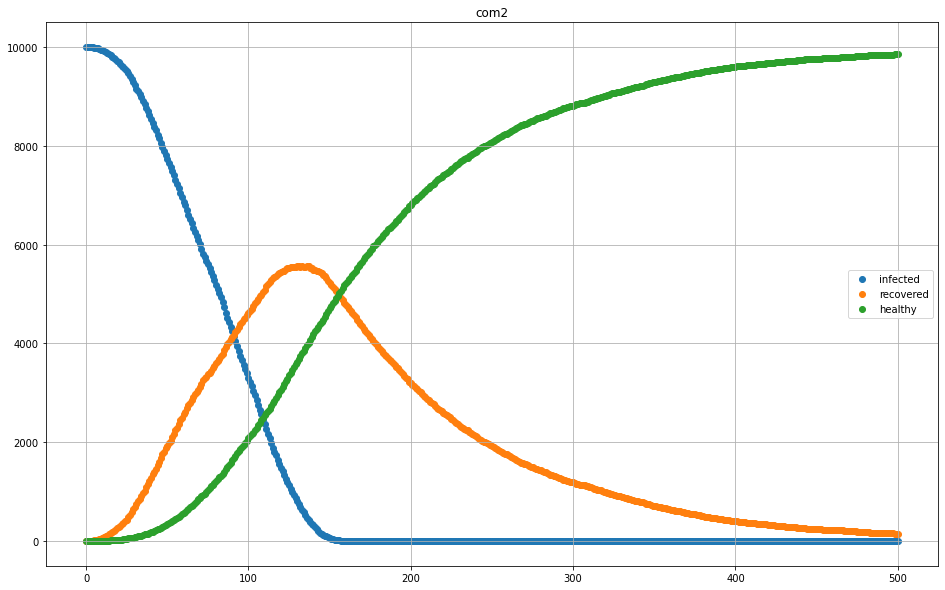

2 

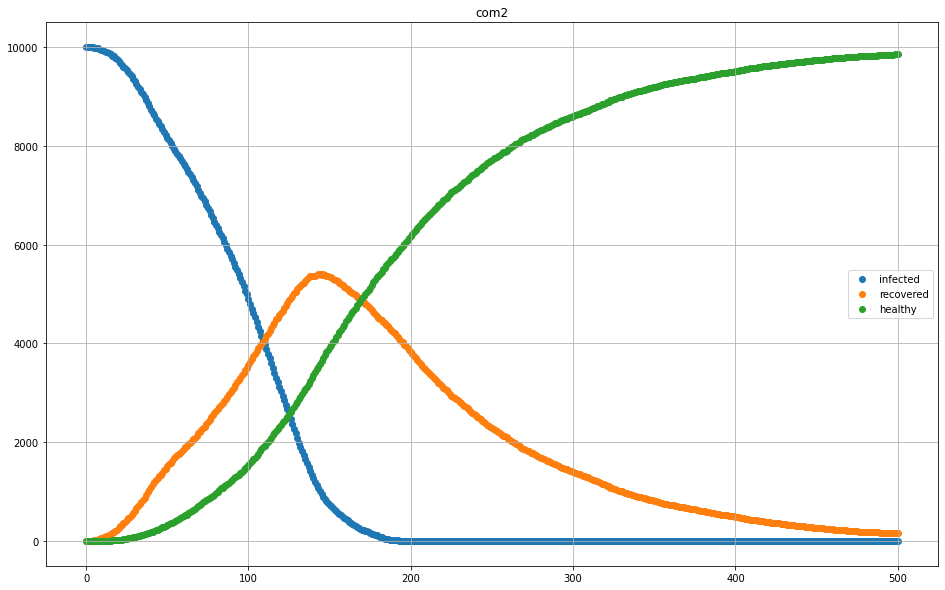

3 

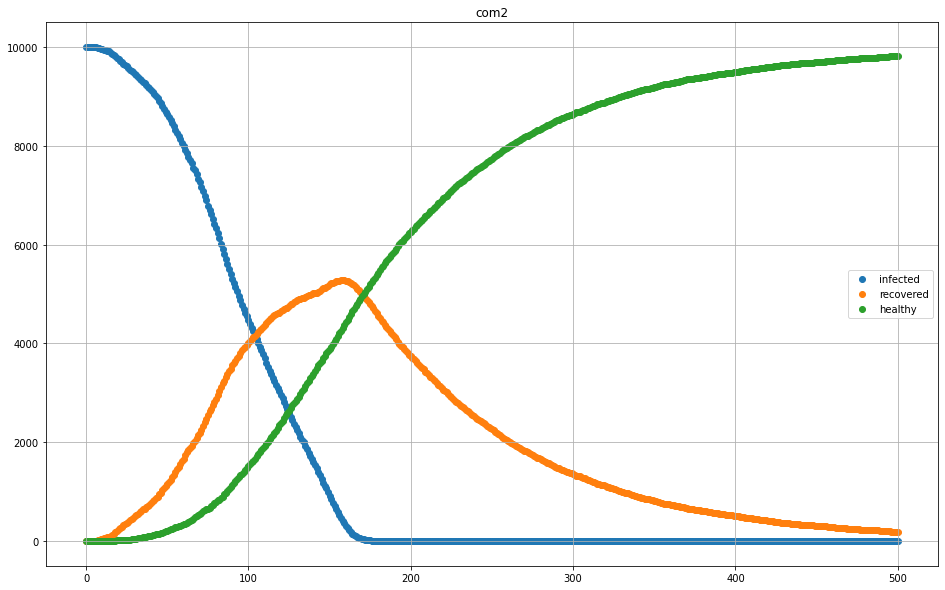

4 

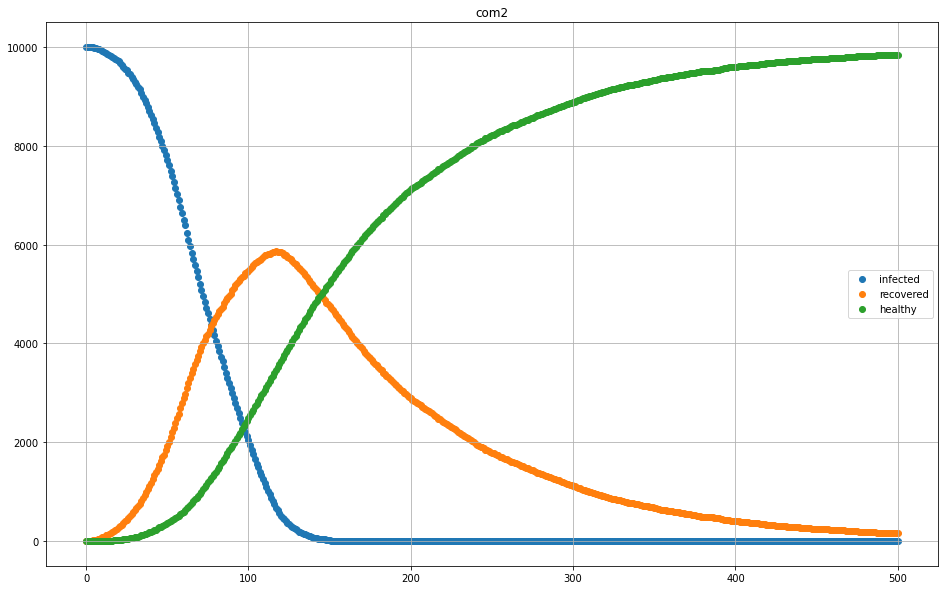

5 

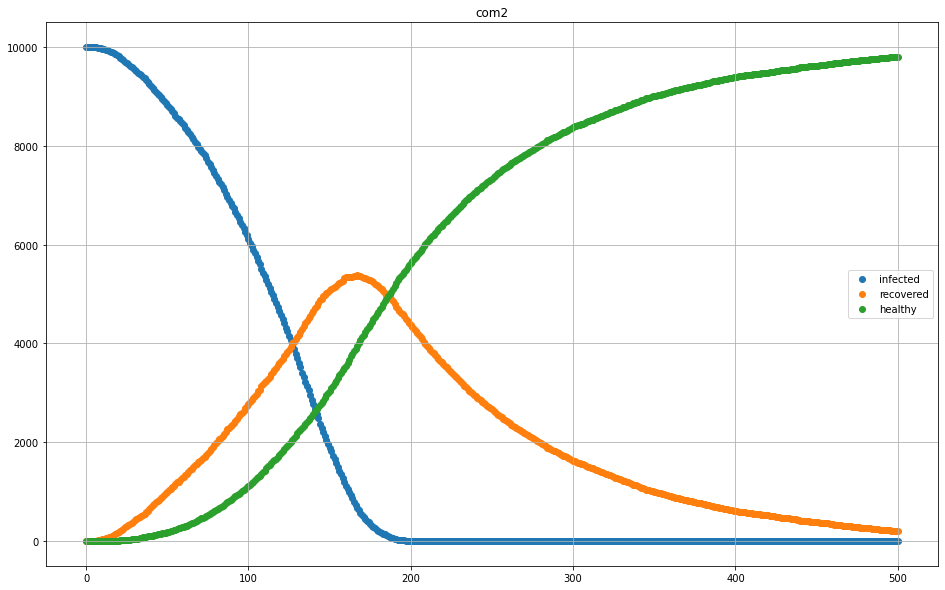

6 

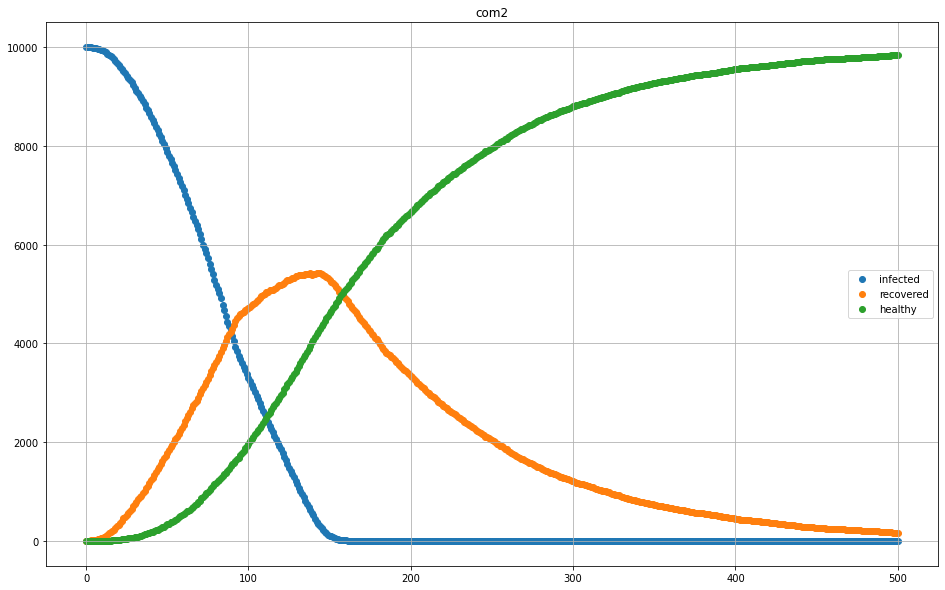

7 

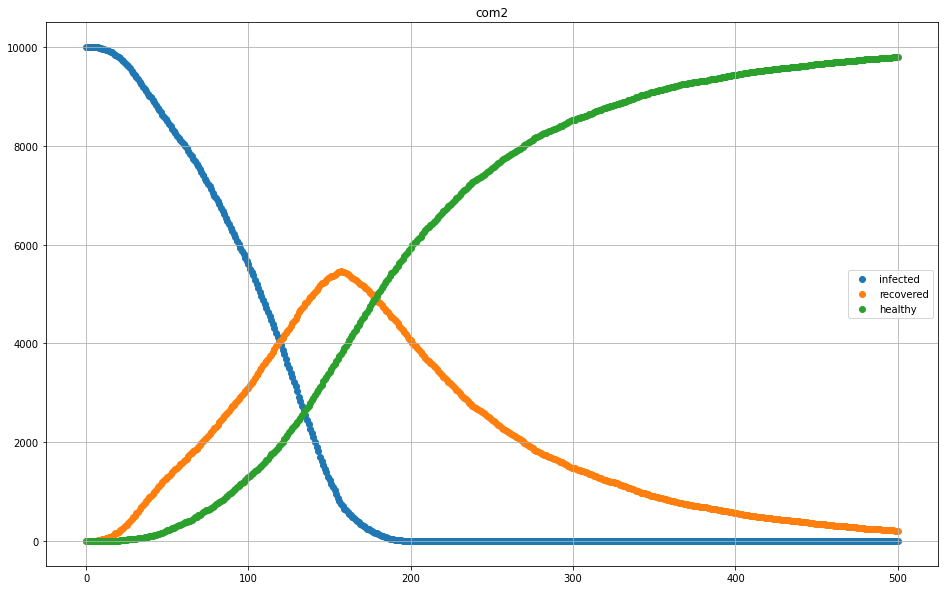

8 

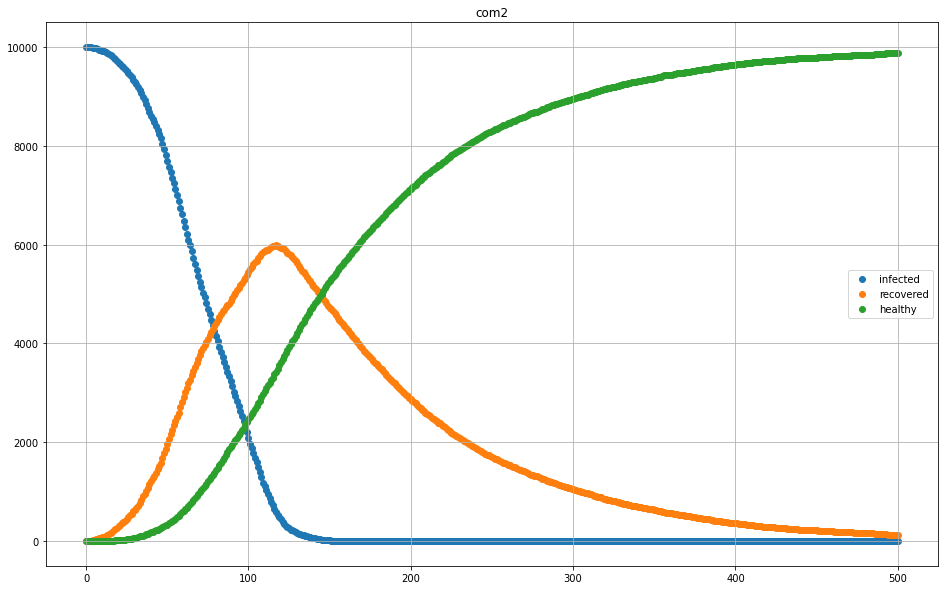

9 

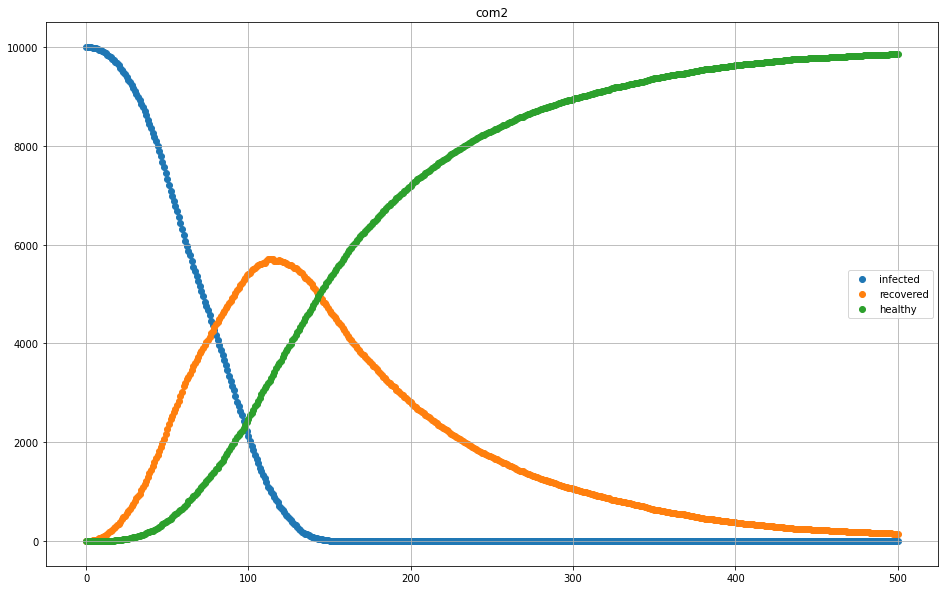

10 

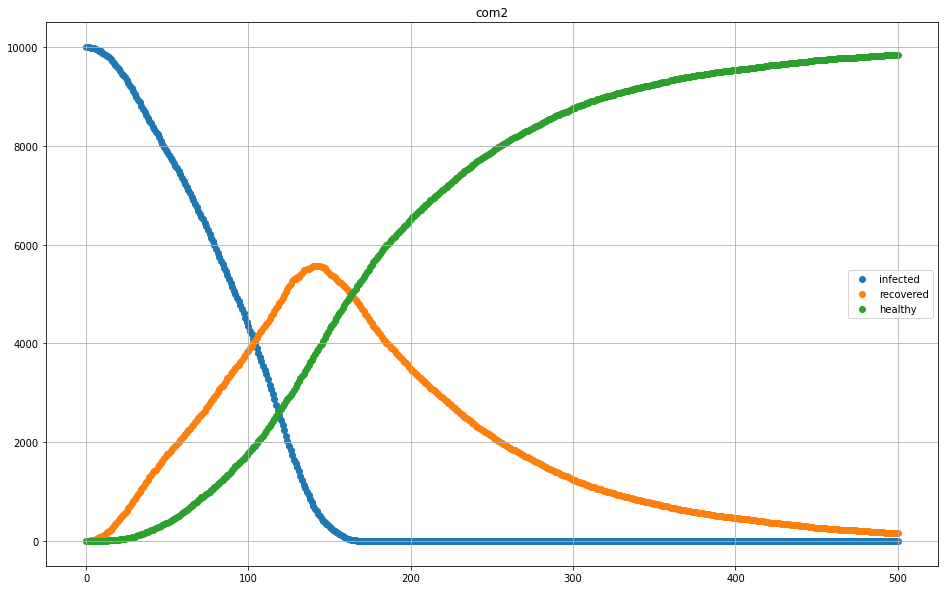

In [0]:
# create the community you'll use in the multiple simulations
com2 = Community('com2', 100)

# set up your community
com2.addInitiallyInfected(1)
com2.setBaseInfectionProbability(0.2)
com2.calculateInfectionProbability(0) # r=0
com2.setRecoveryProbability(0.01)

# put the community inside a dictionary, where the key is its name and the value is the Community object
s1InputDict = {com2.getName(): com2}

# instantiate the simulator
s1 = Simulator(s1InputDict)

# make the multiple simulations by giving a number of time steps per simulation, as well as the number of simulations (450 and 100 here)
s1.multipleSimulationsOfSameSIRScenario(500, 10, 1, plot=True)

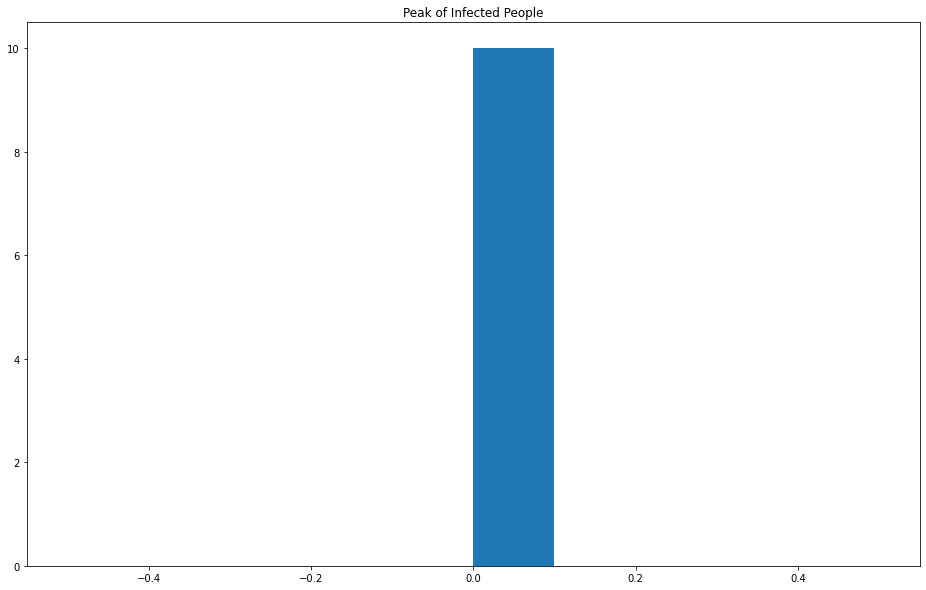

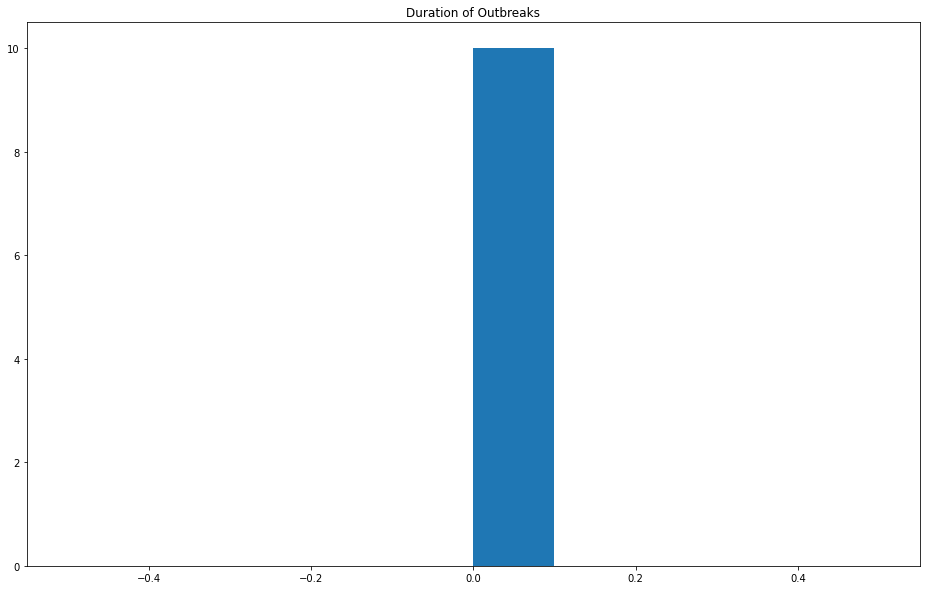

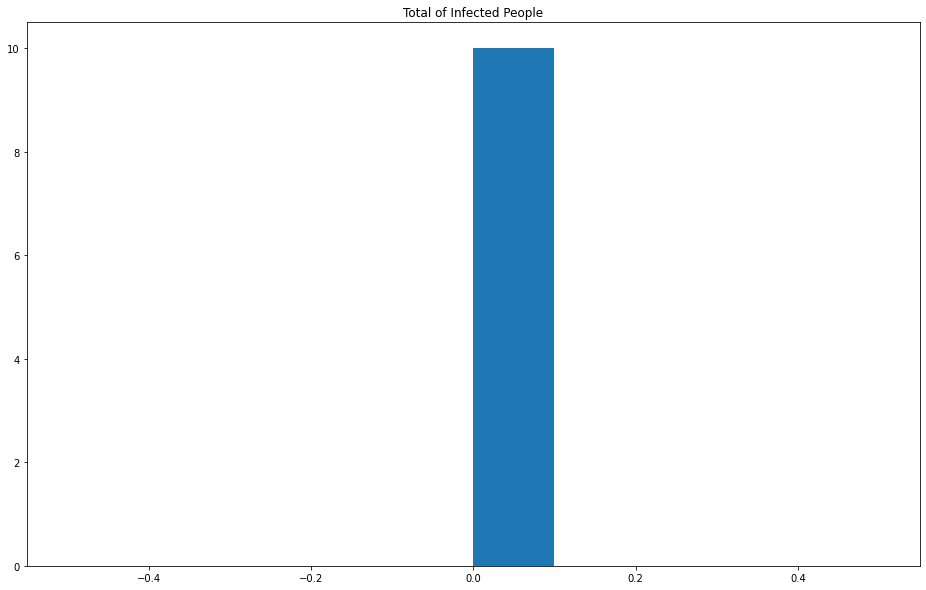

dict_keys(['max_infected_array', 'total_infected_array', 'duration_array'])

In [0]:
# get the dictionary with the results for this community
com2SimulationsResultsDict = s1.resultsDict[com2.getName()]

bins = 10
# show histograms of the simulations' peaks and outbreaks' durations, as well as the total of sick people throughout the duration of the outbreak
plt.hist(com2SimulationsResultsDict['max_infected_array'], bins=bins)
plt.title('Peak of Infected People')
plt.show()

plt.hist(com2SimulationsResultsDict['duration_array'], bins=bins)
plt.title('Duration of Outbreaks')
plt.show()

plt.hist(com2SimulationsResultsDict['total_infected_array'], bins=bins)
plt.title('Total of Infected People')
plt.show()

com2SimulationsResultsDict.keys()

### Simulating migration





In [0]:
# create community with no infected people
com1 = Community('com1', 100)

# set up your community
com1.addInitiallyInfected(0)
com1.setBaseInfectionProbability(0.2)
com1.calculateInfectionProbability(0) # r=0
com1.setRecoveryProbability(0.05)

# create the community which will infect the other via migration
com2 = Community('com2', 1000)

# set up your community
com2.addInitiallyInfected(10000)
com2.setBaseInfectionProbability(0.1)
com2.calculateInfectionProbability(0) # r=0
com2.setRecoveryProbability(0.1)

# put the community inside a dictionary, where the key is its name and the value is the Community object
s1InputDict = {
    com1.getName(): com1,
    com2.getName(): com2
    }

# instantiate the simulator
s1 = Simulator(s1InputDict)

s1.migrationSimulationofTwoCommunities(com1, com2, numSwapped = 10, simulationSteps = 200, plot=True)

In [0]:
com_dict = dict()

num_simulations = 100
for i in range(num_simulations):
  com1 = Community('com1', 100)

  # set up your community
  com1.addInitiallyInfected(0)
  com1.setBaseInfectionProbability(0.2)
  com1.calculateInfectionProbability(0) # r=0
  com1.setRecoveryProbability(0.05)

  # create the community which will infect the other via migration
  com2 = Community('com2', 100)

  # set up your community
  com2.addInitiallyInfected(100)
  com2.setBaseInfectionProbability(0.15)
  com2.calculateInfectionProbability(0) # r=0
  com2.setRecoveryProbability(0.1)

  # put the community inside a dictionary, where the key is its name and the value is the Community object
  s1InputDict = {
      com1.getName(): com1,
      com2.getName(): com2
      }

  # instantiate the simulator
  s1 = Simulator(s1InputDict)

  s1.migrationSimulationofTwoCommunities(com1, com2, numSwapped = 10, simulationSteps = 200, plot=False)
  com_dict[i] = [com1, com2]

In [0]:
com_dict[0][0].SIR[0].max(), com_dict[0][0].SIR[1].max(), com_dict[0][0].SIR[2].max()

max_infected = np.zeros((2,num_simulations))
for key in com_dict:
  max_infected[0,key] = com_dict[key][0].SIR[1].max()
  max_infected[1,key] = com_dict[key][1].SIR[1].max()

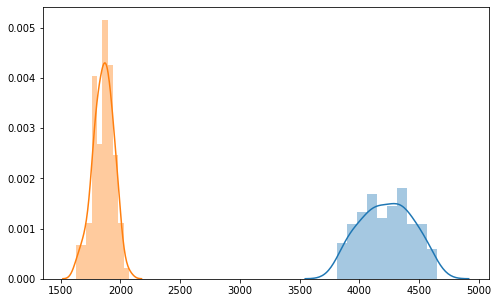

In [0]:
import seaborn as sns
sns.distplot(max_infected[0], bins=10)
sns.distplot(max_infected[1], bins=10)

In [0]:
    self.recovery_probability = 0 # this is the probability of recovering if the person is infected
    self.peak_number_of_infections = 0 # this is the peak number of infected people at the same time during the simulation
    self.total_infections = 0 # this is the total number of people that were infected or are currently infected at the time where the outbreak ends
    self.duration_of_outbreak = 0 # this is the number of time steps that the outbreaks lasts, calculated to be the 
                                  # time step after the peak where the number of infected is for the first time less 
                                  # than 10% of the peak number of infected 

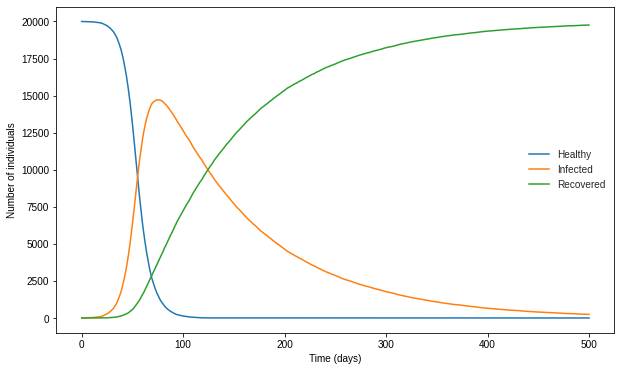

In [0]:
plt.figure(figsize=(10,6))
comb_sir = com1.SIR + com2.SIR
plt.plot(com1.time, comb_sir[0], label='Healthy')#, color='plum')
plt.plot(com1.time, comb_sir[1], label='Infected')#, color='orange')
plt.plot(com1.time, comb_sir[2], label='Recovered')#, color='green')

plt.style.use('seaborn')
plt.ylabel('Number of individuals')
plt.xlabel('Time (days)')
plt.legend()
plt.savefig('SIR_model')

### Simulating multiple SIR scenarios multiple times with the Simulator Class

Here we compare three communitites that are exactly the same, varying their social distance (0%, 25% and 50% respectevely). Each community is simulated a 100 times.

In [0]:
# create the communities you'll use in the multiple simulations
com3 = Community('com3', 100)
com4 = Community('com4', 100)
com5 = Community('com5', 100)

# set up your communities, the only difference between these is that they've social distancing of .0, .25, and .5 respectively
com3.addInitiallyInfected(1)
com4.addInitiallyInfected(1)
com5.addInitiallyInfected(1)


com3.setBaseInfectionProbability(0.2)
com4.setBaseInfectionProbability(0.2)
com5.setBaseInfectionProbability(0.2)

com3.calculateInfectionProbability(0) # r=0
com4.calculateInfectionProbability(0.25) # r=0.25
com5.calculateInfectionProbability(0.5) # r=0.5

com3.setRecoveryProbability(0.01)
com4.setRecoveryProbability(0.01)
com5.setRecoveryProbability(0.01)

# put the communities inside a dictionary, where the key is its name and the value is the Community object
s2InputDict = {com3.getName(): com3,
               com4.getName(): com4,
               com5.getName(): com5}

# instantiate the simulator
s2 = Simulator(s2InputDict)

# make the multiple simulations by giving a number of time steps per simulation, as well as the number of simulations (600 and 100 here)
s2.multipleSimulationsOfSameSIRScenario(600, 100)

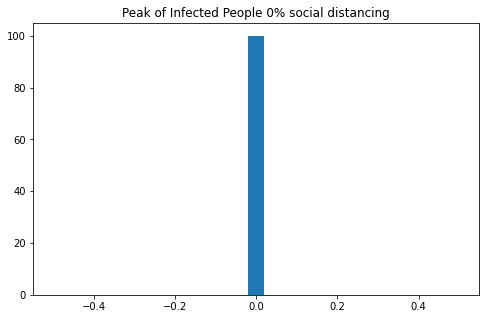

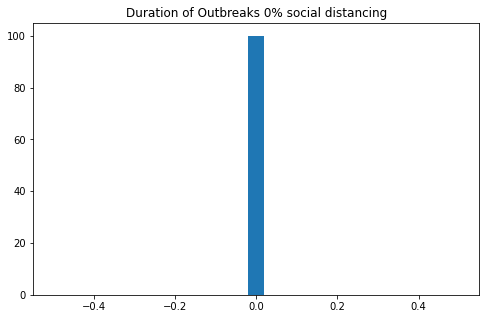

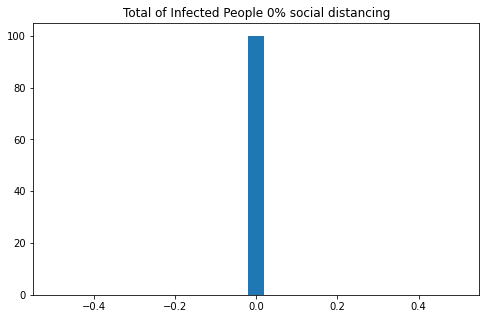

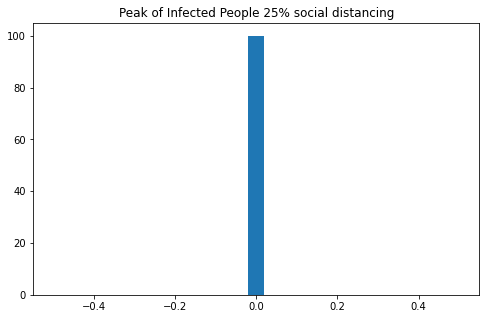

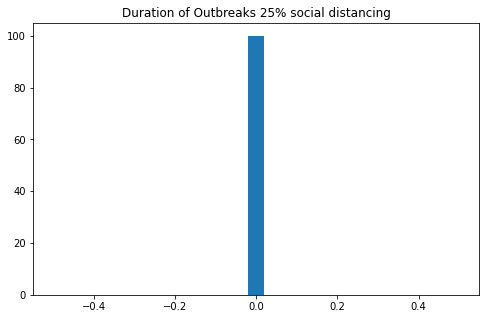

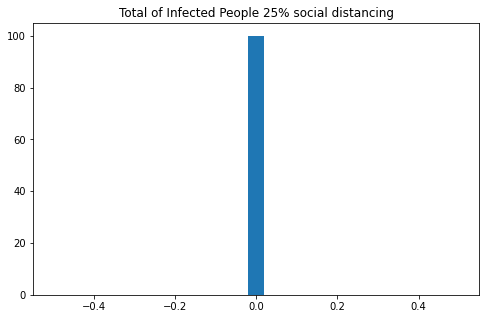

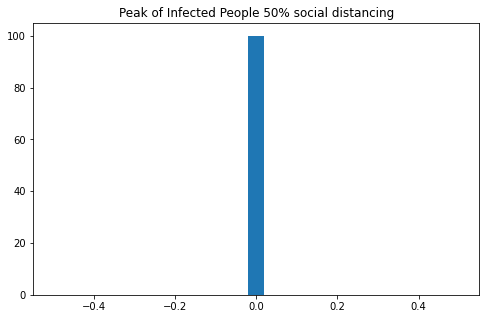

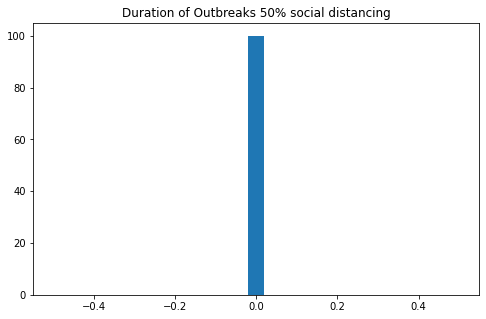

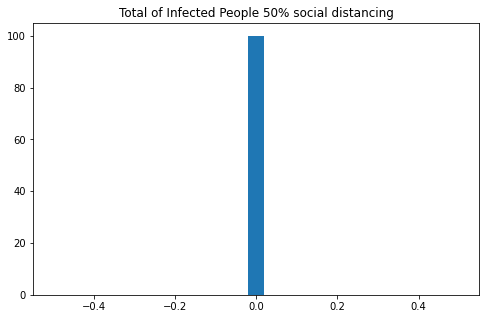

In [0]:
plt.rcParams['figure.figsize'] = (8,5)
# get the dictionary with the results for each community
com3SimulationsResultsDict = s2.resultsDict[com3.getName()]
com4SimulationsResultsDict = s2.resultsDict[com4.getName()]
com5SimulationsResultsDict = s2.resultsDict[com5.getName()]

# show histograms of the simulations' peaks and outbreaks' durations, as well as the total of sick people throughout the duration of the outbreak
plt.hist(com3SimulationsResultsDict['max_infected_array'], bins=20)
plt.title('Peak of Infected People 0% social distancing')
plt.show()

plt.hist(com3SimulationsResultsDict['duration_array'], bins=25)
plt.title('Duration of Outbreaks 0% social distancing')
plt.show()

plt.hist(com3SimulationsResultsDict['total_infected_array'], bins=25)
plt.title('Total of Infected People 0% social distancing')
plt.show()

# show histograms of the simulations' peaks and outbreaks' durations, as well as the total of sick people throughout the duration of the outbreak
plt.hist(com4SimulationsResultsDict['max_infected_array'], bins=25)
plt.title('Peak of Infected People 25% social distancing')
plt.show()

plt.hist(com4SimulationsResultsDict['duration_array'], bins=25)
plt.title('Duration of Outbreaks 25% social distancing')
plt.show()

plt.hist(com4SimulationsResultsDict['total_infected_array'], bins=25)
plt.title('Total of Infected People 25% social distancing')
plt.show()

# show histograms of the simulations' peaks and outbreaks' durations, as well as the total of sick people throughout the duration of the outbreak
plt.hist(com5SimulationsResultsDict['max_infected_array'], bins=25)
plt.title('Peak of Infected People 50% social distancing')
plt.show()

plt.hist(com5SimulationsResultsDict['duration_array'], bins=25)
plt.title('Duration of Outbreaks 50% social distancing')
plt.show()

plt.hist(com5SimulationsResultsDict['total_infected_array'], bins=25)
plt.title('Total of Infected People 50% social distancing')
plt.show()

In [0]:
com1 = Community('com1', 100)

com1.setBaseInfectionProbability(0.2)
com1.calculateInfectionProbability(0)
com1.setRecoveryProbability(0.01)
com1.addInitiallyInfected(1)

for i in range(1000):
  com1.simulateOneTimeStep()

(0.0, 10000.0)

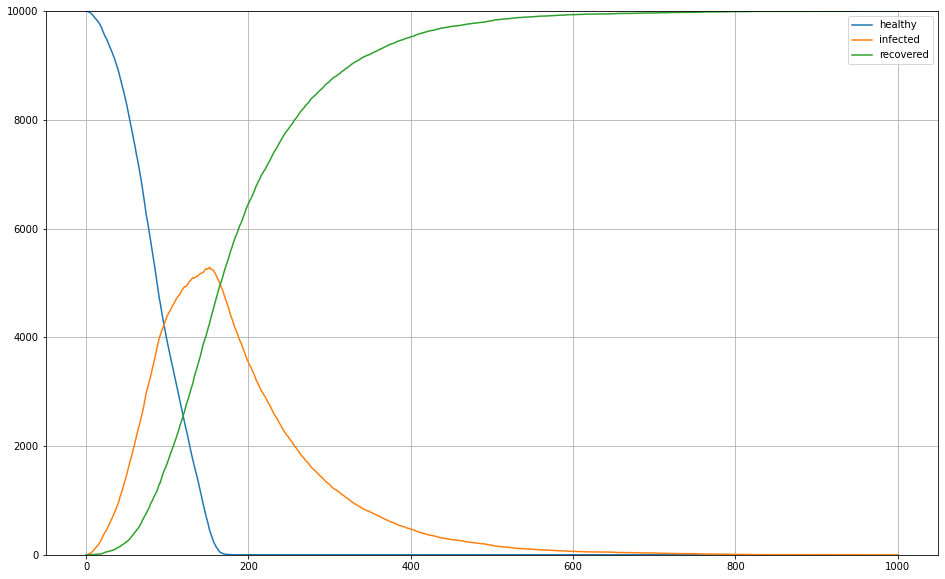

In [0]:
x = np.arange(com1.SIR.shape[1])
plt.plot(x, com1.SIR[0,:], ms=10, label='healthy')
plt.plot(x, com1.SIR[1,:], ms=10, label='infected')
plt.plot(x, com1.SIR[2,:], ms=10,label='recovered')

plt.legend()
plt.grid()
plt.ylim((0,com1.getPopulation()))

In [0]:
def funcCheck(func, *args):
  print(func(*args))
def compareX(x,y):
  return x > y

funcCheck(compareX, 3,3)

False


In [0]:
grid = np.zeros((100,100))
def applyCondition(func, *args):
    grid[func(*args)] = 1

def conditional1(prob_matrix, conditional_prob):
  return prob_matrix > conditional_prob

applyCondition(conditional1, np.random.rand(100,100), 0.05)

In [0]:
com1.SIR.shape
com1.additionalGroups = np.zeros((1,201))
(com1.SIR+com1.additionalGroups).shape

(3, 201)

In [0]:
np.concatenate(com1.SIR,com1.additionalGroups)

In [0]:
com1.additionalGroups[0,0]

0.0

In [0]:
com1.SIR = np.concatenate([com1.SIR, com1.additionalGroups])

In [0]:
generateIndices()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def generateIndices(command):
  prob_matrix = np.random.rand(100, 100)
  return prob_matrix < command